In [1]:
import warnings
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pandas as pd
import numpy as np
import yfinance as yf
warnings.filterwarnings('ignore')

In [2]:
pip install --upgrade yfinance


Note: you may need to restart the kernel to use updated packages.


In [3]:
data = fdr.DataReader('005930')
data

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1999-12-03,5060,5200,5020,5120,892690,NaN
1999-12-06,5180,5500,5170,5500,1096821,0.074219
1999-12-07,5500,5600,5420,5570,907656,0.012727
1999-12-08,5560,5590,5400,5470,730112,-0.017953
1999-12-09,5360,5460,5310,5400,1092752,-0.012797
...,...,...,...,...,...,...
2024-03-21,79200,79300,77700,79300,44569799,0.031209
2024-03-22,79600,79900,77800,78900,26724761,-0.005044
2024-03-25,79600,79800,77800,78200,18703996,-0.008872


In [4]:
close = data['Close']

start_data = '2021-10-01'
end_data = '2023-12-22'

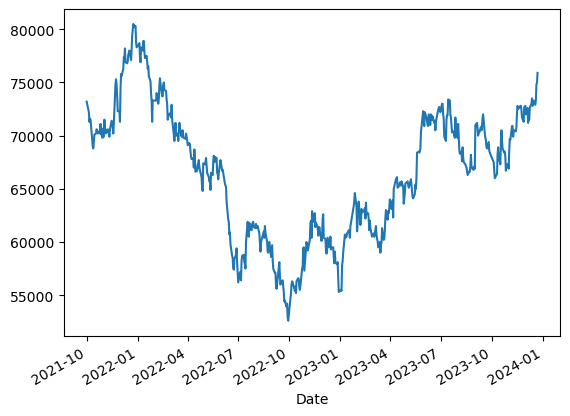

In [5]:
#기존 구간 시계열 차트
close[start_data:end_data].plot();

In [6]:
#기준점이 되는 종가의 범위 부분을 base에 넣음
base = close[start_data:end_data]
base

Date
2021-10-01    73200
2021-10-05    72200
2021-10-06    71300
2021-10-07    71600
2021-10-08    71500
              ...  
2023-12-18    72900
2023-12-19    73400
2023-12-20    74800
2023-12-21    75000
2023-12-22    75900
Name: Close, Length: 551, dtype: int64

In [7]:
#모든 수의 범위를 0과 1 사이로 정교한 진행
base_norm = (base - base.min()) / (base.max() - base.min())
base_norm

Date
2021-10-01    0.738351
2021-10-05    0.702509
2021-10-06    0.670251
2021-10-07    0.681004
2021-10-08    0.677419
                ...   
2023-12-18    0.727599
2023-12-19    0.745520
2023-12-20    0.795699
2023-12-21    0.802867
2023-12-22    0.835125
Name: Close, Length: 551, dtype: float64

In [8]:
#윈도우 사이즈(중간에 휴일을 제거한 날짜수)
window_size = len(base)
#예측 기간
next_date = 5
#검색 횟수
moving_cnt = len(close) - window_size - next_date - 1

In [9]:
#코사인 유사도 1에 가까울수록 유사성 up 
def cosine_similarity(x,y):
    return np.dot(x,y) / (np.sqrt(np.dot(x,x)) * np.sqrt(np.dot(y,y)))

In [10]:
#유사도 저장 딕셔너리
sim_list = []

for i in range(moving_cnt):
    target = close[i:i+window_size]
    #Normalize
    target_norm = (target - target.min()) / (target.max() - target.min())
    #코사인 유사도 저장
    cos_similarity = cosine_similarity(base_norm, target_norm)
    #코사인 유사도 <- i(인덱스), 시계열 데이터 함께 저장
    sim_list.append(cos_similarity)

In [11]:
#코사인 유사도를 기준으로 내림차순 정리
pd.Series(sim_list).sort_values(ascending = False).head(20)

5387    1.000000
5388    0.998255
5386    0.998252
5385    0.996547
5389    0.996546
5390    0.995234
5384    0.995207
5391    0.993892
5383    0.993841
5392    0.992657
5382    0.992560
5393    0.991632
5381    0.991386
5394    0.990362
5380    0.989972
5395    0.989183
5379    0.988641
5396    0.987970
5378    0.987234
5397    0.986256
dtype: float64

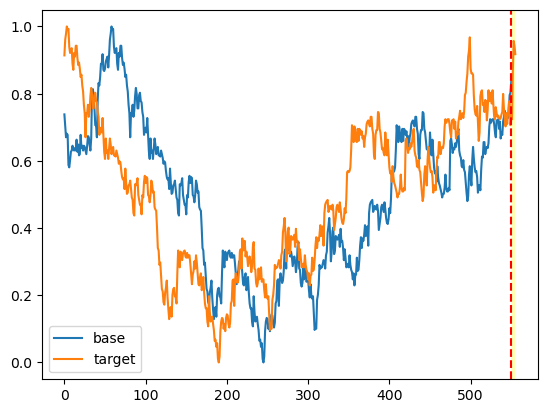

In [12]:
idx = 5442 
top_=close[idx:idx+window_size+next_date]
top_norm = (top_-top_.min()) / (top_.max()-top_.min())

plt.plot(base_norm.values, label = 'base')
plt.plot(top_norm.values, label = 'target')
plt.axvline(x=len(base_norm)-1, c='r', linestyle='--')
plt.axvspan(len(base_norm.values)-1, len(top_norm.values)-1, facecolor='yellow', alpha=0.3)
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed

pred: nan % 


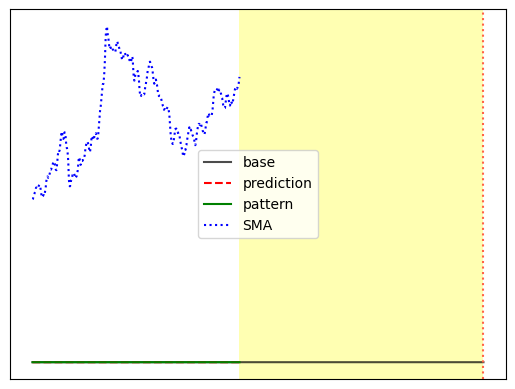

In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib.figure import Figure

class PatternFinder():
    def __init__(self, period=5):
        self.period = period

    def set_stock(self, code: str):
        self.code = code
        self.data = yf.download(code, start="2013-01-01", end="2023-12-31")
        self.close = self.data['Close']
        self.change = self.data['Close'].pct_change().dropna()
        return self.data

    def search(self, start_date, end_date, threshold=0.98):
        base = self.close[start_date:end_date]
        self.base_norm = (base - base.min()) / (base.max() - base.min())
        self.base = base

        window_size = len(base)
        moving_cnt = len(self.data) - window_size - self.period - 1
        cos_sims = self.__cosine_sims(moving_cnt, window_size)

        self.window_size = window_size
        cos_sims = cos_sims[cos_sims > threshold]
        return cos_sims

    def __cosine_sims(self, moving_cnt, window_size):
        def cosine_similarity(x, y):
            return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

        sim_list = []

        for i in range(moving_cnt):
            target = self.close[i:i+window_size]
            target_norm = (target - target.min()) / (target.max() - target.min())
            cos_similarity = cosine_similarity(self.base_norm, target_norm)
            sim_list.append(cos_similarity)

        return pd.Series(sim_list).sort_values(ascending=False)

    def moving_average(self, window_size):
        self.sma = self.close.rolling(window=window_size).mean()

    def plot_pattern(self, idx, period=5):
        if period != self.period:
            self.period = period

        top = self.close[idx:idx+self.window_size+period]
        top_norm = (top - top.min()) / (top.max() - top.min())
        fig = Figure()
        axis = fig.add_subplot(1, 1, 1)
        axis.plot(self.base_norm.values, label='base', color='black', alpha=0.7)
        axis.plot(top_norm.values, label='prediction', color='red', linestyle='dashed')
        axis.plot(top_norm.values[:len(self.base_norm.values)], label='pattern', color='green', linestyle='solid')
        axis.plot(self.sma.values[idx:idx+self.window_size+period], label='SMA', color='blue', linestyle='dotted')
        axis.axvline(x=len(self.base_norm)-1, c='tomato', linestyle='dotted')
        axis.axvspan(len(self.base_norm.values)-1, len(top_norm.values)-1, facecolor='yellow', alpha=0.3)
        axis.legend()
        axis.get_yaxis().set_visible(False)
        axis.get_xaxis().set_visible(False)

        preds = self.change[idx+self.window_size: idx+self.window_size+period]
        print(f'pred: {preds.mean()*100} % ')
        return fig

    def stat_prediction(self, results, period=5):
        idx_list = list(results.keys())
        mean_list = []
        for idx in idx_list:
            pred = self.change[idx+self.window_size: idx+self.window_size+period]
            mean_list.append(pred.mean())
        return np.array(mean_list)

# PatternFinder 객체 생성
p = PatternFinder()
p.set_stock('005930.KS')  # Specify the market (KS for KRX)

# 창을 10일로 설정하여 SMA 계산 (이 부분을 조정할 수 있습니다)
p.moving_average(window_size=10)

# 검색 수행 및 패턴 플로팅
result = p.search('2013-12-27', '2023-12-27')
p.plot_pattern(1575)




In [14]:
p=PatternFinder()

In [30]:
p.set_stock('035420') #stock code

[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['035420']: Exception('%ticker%: No timezone found, symbol may be delisted')


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [31]:
p.moving_average(window_size=10)

In [36]:
result = p.search('2024-01-12', '2024-03-25') #period


In [34]:
result

Series([], dtype: object)

pred: -0.13132567481789925 % 


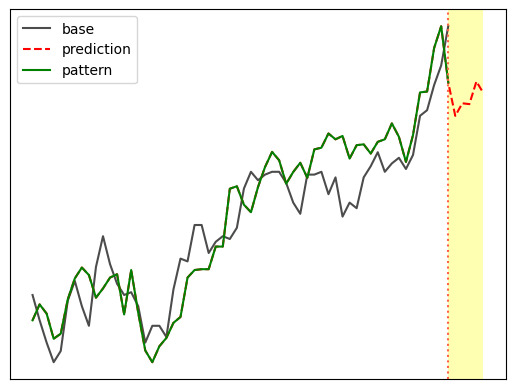

In [20]:
p.plot_pattern(4230) #cosine_sim_code

In [37]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

sec = pdr.get_data_yahoo('005930.KS', start = '2018-05-04')
msft = pdr.get_data_yahoo('MSFT', start = '2018-05-04')

ModuleNotFoundError: No module named 'pandas_datareader'